# Machine Learning Engineer Nanodegree
## Capstone Project
Ian Gregson
September 22nd 2018

### Benchmark

In [5]:
# Let's load up our std libraries and start having some fun

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

# Set up some necessary constants
SPLIT_RANDOM_SEED = 42
DCLF_RANDOM_SEED = 42
K_FOLD_RANDOM_SEED = 3
K_FOLDS = 5
K_FEATURES = 50
NA_THRESHOLD = 0.975
LABEL_COLUMN = 'StageName'

#### Metrics

In [6]:
#  Set up a scoring function that uses the f1 score metric
from sklearn.metrics import f1_score, make_scorer
f1_scorer = make_scorer(f1_score)

#### Dummy Classifier

In [7]:
#  Set up the dummy classifier
from sklearn.dummy import DummyClassifier
dclf = DummyClassifier(random_state=DCLF_RANDOM_SEED)

#### Benchmark

In [8]:
# First up, load the raw dataset
raw_data = pd.read_csv('data/csv/selected_columns.csv', low_memory=False)

# Drop rows with labels that are not relevant and separate features from labels
data = utils.drop_rows(raw_data)
labels = utils.get_labels(data, label_column=LABEL_COLUMN)
features = data.drop(columns=[LABEL_COLUMN], axis=1)

# One hot encode categorical features
features = utils.encode(features)

# Drop null columns
features = utils.drop_na_columns(features, label_column=LABEL_COLUMN, na_threshold=NA_THRESHOLD)

# Drop correlated features
features = utils.drop_corr_columns(features, labels)

# Train test split
X_train, X_test, y_train, y_test = utils.data_split(features, labels, random_state=SPLIT_RANDOM_SEED)

# Feature scaling
from sklearn.preprocessing import MaxAbsScaler

max_abs_scaler = MaxAbsScaler()
X_train = max_abs_scaler.fit_transform(X_train)
X_test = max_abs_scaler.fit_transform(X_test)

# Feature selection
X_train = utils.feature_selection(X_train, y_train, K_FEATURES)
X_test = utils.feature_selection(X_test, y_test, K_FEATURES)

# Score the dummy classifier
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=K_FOLDS, random_state=K_FOLD_RANDOM_SEED)
cv_results = model_selection.cross_val_score(dclf, X_train, y_train, cv=kfold, scoring=f1_scorer)
display('Mean f1_score from KFold cross validation {:0.2f}'.format(cv_results.mean()))

'Mean f1_score from KFold cross validation 0.59'

In [9]:
features.to_csv('data/csv/processed_features.csv', index=False)

The DummyClassifier achieves an average of **f1 score** 59%. This establishes a baseline for assessing the success of the final modal. Given the dataset, a guess could be expected to be accurate in 59% of predictions. In order to demonstrate that the final model built in the project is better than a guess, it must a achieve a better average f1 score than 59%.

### Model selection

LR: 0.934842 (0.003276)
NB: 0.897618 (0.017178)
KNN: 0.942352 (0.005056)
SVM: 0.914069 (0.003355)
RF: 0.988457 (0.000680)
LGBM: 0.990637 (0.000814)
XGB: 0.990019 (0.001041)


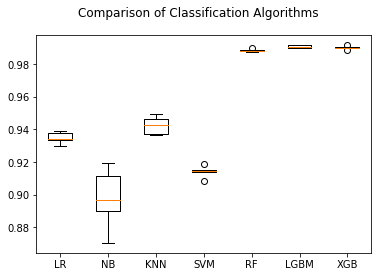

In [24]:
# Importing libraries
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Preparing models
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('LGBM', lgb.sklearn.LGBMClassifier(objective='binary')))
models.append(('XGB', xgb.XGBClassifier()))

# Model Evaluation
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=K_FOLDS, random_state=K_FOLD_RANDOM_SEED)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=f1_scorer)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot to compare algorithms
fig = plt.figure()
fig.suptitle('Comparison of Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Testing

In [25]:
from sklearn.model_selection import GridSearchCV

gridParams = {
    'n_estimators': [50,100,150],
    'num_leaves': [15,31,45,60],
    'max_bin': [125,255,380],
    'objective' : ['binary'],
}

model = lgb.sklearn.LGBMClassifier(objective='binary')
tuned_model = GridSearchCV(model, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)

model.fit(X_train, y_train)
tuned_model.fit(X_train, y_train)
y_pred = model.predict(X_test)
tuned_y_pred = tuned_model.predict(X_test)

scores = {
    'model': f1_score(y_pred, y_test),
    'tuned_model': f1_score(tuned_y_pred, y_test),
}

display(scores)

# final_model = lgb.sklearn.LGBMClassifier(
#     n_estimators=model.best_params_['n_estimators'],
#     num_leaves=model.best_params_['num_leaves'],
#     objective=model.best_params_['objective'],
#     max_bin=model.best_params_['max_bin']
# )
# final_model.fit(X_train, y_train)
# y_pred = final_model.predict(X_test)
# score = f1_score(y_pred, y_test)
# display(score)

{'model': 0.9872278664731496, 'tuned_model': 0.9861938671704693}

### Refinement

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_


#### Hyper Parameter Grid Search

## 4. Results

### Model Evaluation and Validation

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


### Jusitifcation

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_


## 5. Conclusion

### Free-Form Visualization

In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_


### Reflection

In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_


### Improvement

In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_


--------------------------------------------------------------------------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?
